In [1]:
import _init_paths
import tensorflow as tf
from fast_rcnn.config import cfg
# The following line specifies CPU operation for importing the following modules.
cfg.USE_GPU_NMS = False
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, sys, cv2
from networks.factory import get_network
% matplotlib inline
import cPickle
import pandas as pd

In [2]:
CLASSES = ('__background__',
           'empty_basket', 'full_basket','empty_cart','full_cart')

# See "/cartwatch/classification/Dataprep_VOC-FRCNN-260217" for train/test split.
NUM_TRAIN_IM = 2194
# See "/cartwatch/classification/all_pics_labelled_copy/Dataprep_VOC-FRCNN-010317" for train/test split.
#NUM_TRAIN_IM = 3164

In [3]:
results_path = "/Users/LukeMiller/Git/tensorflow_faster_rcnn/output/faster_rcnn_end2end_010317/voc_2007_test"
results_file = os.path.join(results_path,'VGGnet_fast_rcnn_iter_%d','%s_pr.pkl')

In [4]:
def load_results(file_in):
        """
        Loads results from pickle file and returns contents
        """
        if os.path.exists(file_in):
            with open(file_in, 'rb') as fid:
                resdb = cPickle.load(fid)
            return resdb

In [5]:
def df_create(cls,selection=[1,100,20]):
    df = pd.DataFrame()
    for n_iter in range(selection[0],selection[1],selection[2]):
        df_temp = pd.DataFrame.from_dict(
                load_results(results_file%(n_iter*1000,cls)), 
                orient="columns")
        #print("Loaded: {}".format(results_file%(n_iter*1000,cls)))
        df_temp['iter'] = pd.Series([n_iter*1000] * len(df_temp.index))
        df = df.append(df_temp)
    return df

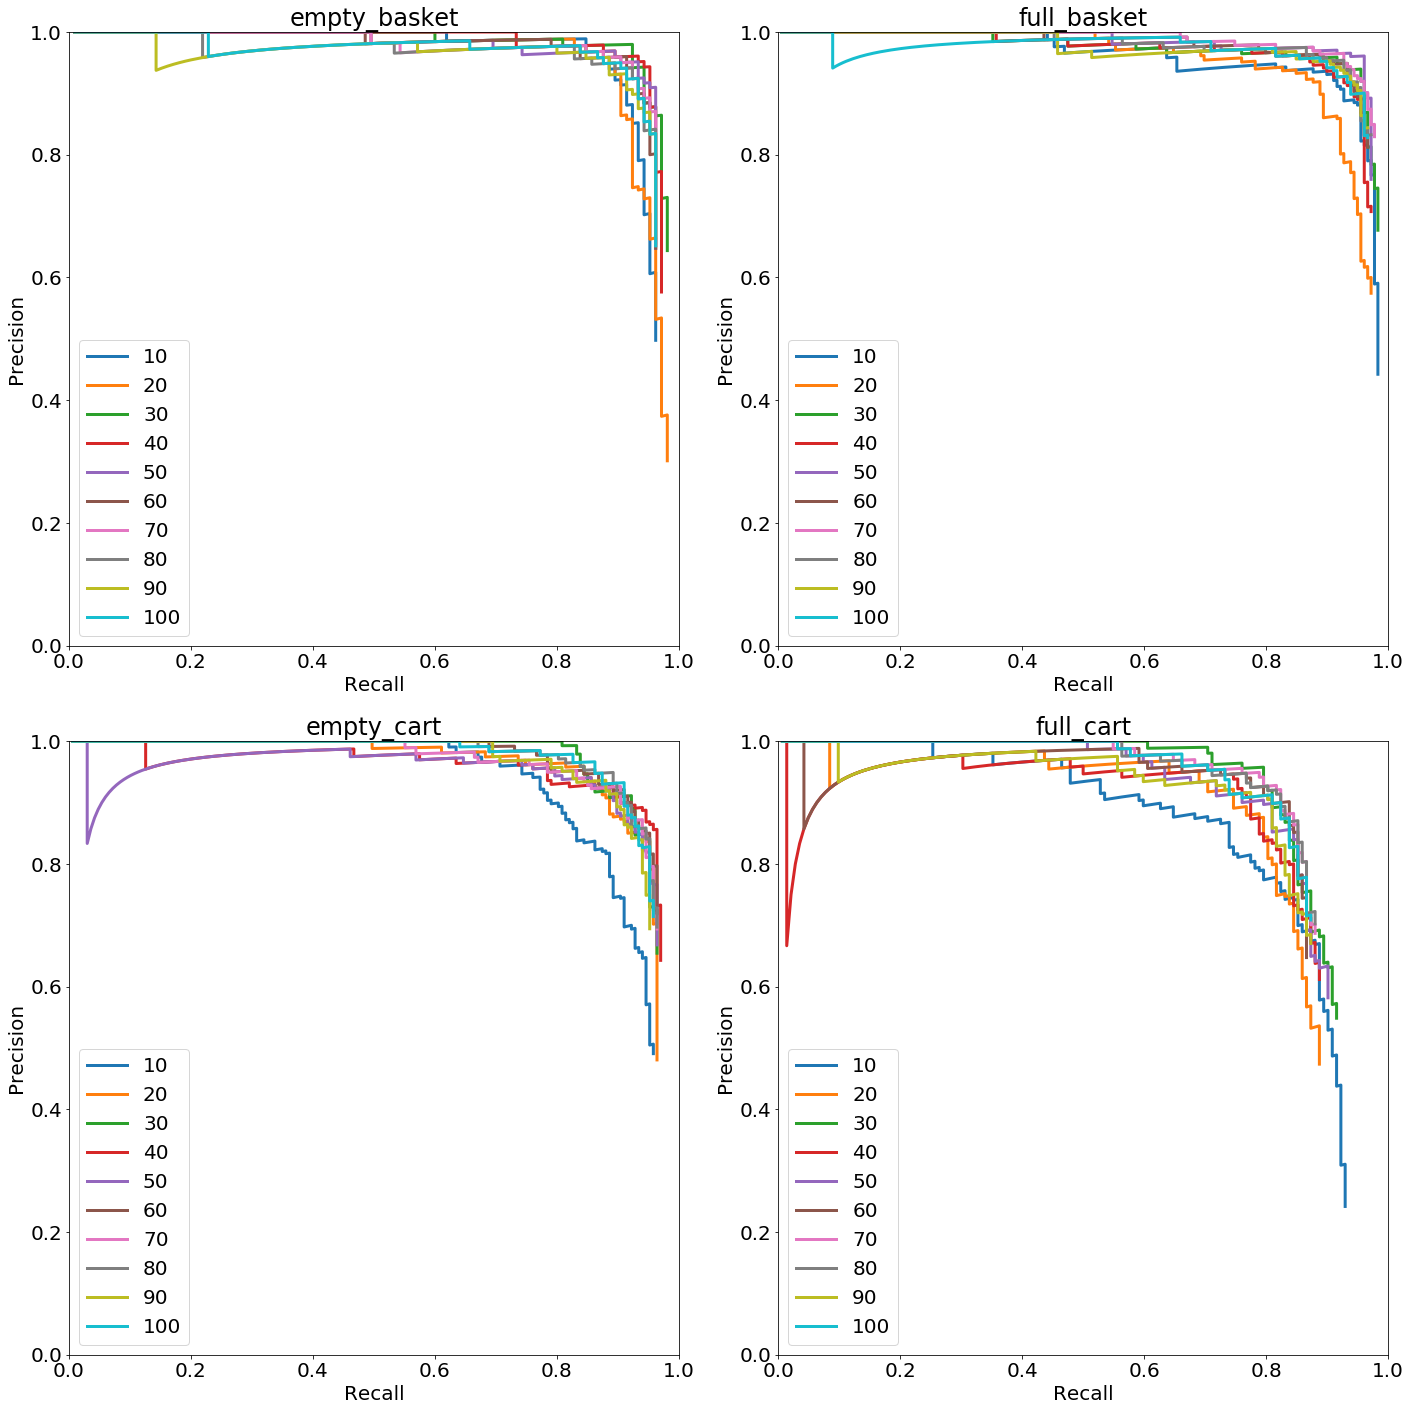

In [6]:
selection=[10,110,10]

# not necessary butyou might want to add options to the figure
plt.figure(figsize=(20, 20))
# set the font size globally to get the ticklabels big too:
plt.rcParams["font.size"] = 20

for n_cls in range(1,5):
    cls = CLASSES[n_cls]
    
    df = df_create(cls,selection)
    s_prec = df['prec']
    s_rec = df['rec']
    s_iter = df['iter']
    
    ax = plt.subplot(2,2,n_cls)

    for n_iter in range(selection[0],selection[1],selection[2]):
        ax.plot(s_rec[s_iter == n_iter*1000].tolist(),
                s_prec[s_iter == n_iter*1000].tolist(), 
                 marker = '', linestyle = '-', linewidth = 3, label="%s"%n_iter)
    ax.set_title(cls)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc = 'lower left')
    ax.axis([0, 1, 0, 1])
    
plt.tight_layout()
plt.savefig('results_010317.png')

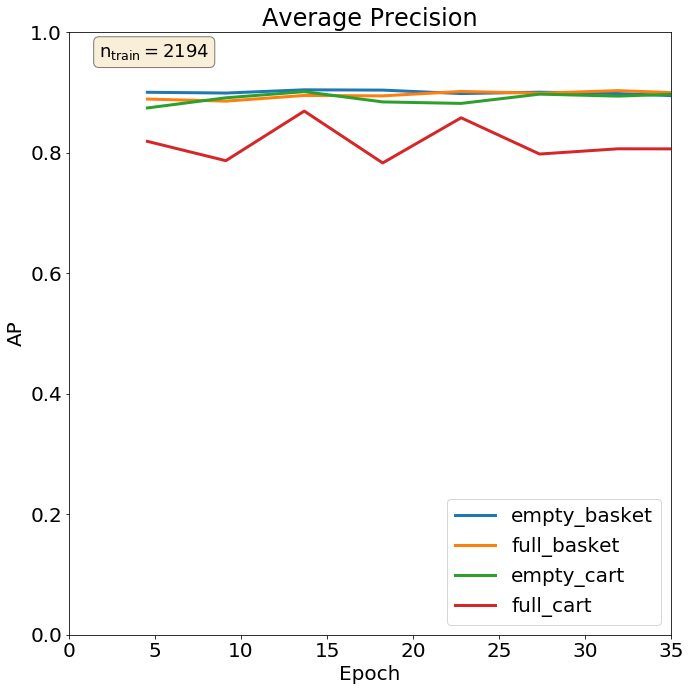

In [7]:
selection=[10,110,10]

# not necessary butyou might want to add options to the figure
plt.figure(figsize=(10, 10))
# set the font size globally to get the ticklabels big too:
plt.rcParams["font.size"] = 20
ax = plt.subplot(1,1,1)
for n_cls in range(1,5):
    cls = CLASSES[n_cls]
    
    df = df_create(cls,selection)
    s_ap = df['ap']
    s_epoch = df['iter']/NUM_TRAIN_IM
    
    ax.plot(s_epoch.tolist(),s_ap.tolist(), 
            marker = '', linestyle = '-', linewidth = 3, label="%s"%cls)
    ax.set_title("Average Precision")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AP')
    ax.legend(loc = 'lower right')
    ax.axis([0, 35, 0, 1])
    
plt.tight_layout()
textstr = '$\mathrm{n_{train}} = %d$'%(NUM_TRAIN_IM)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)
plt.savefig('results_ap_010317.png')